# Simple Linear Regression

Let's continue with the cars data, but this time let's formally recognize that a car's weight might have some effect on city MPG.  Assume

$$ Y_1, \ldots, Y_N \sim_{iid} \text{Normal}(\mu, \sigma^2) \\
\mu = \beta_0 + \beta_1 * weight.$$

We again focus on the expected value, not $\sigma$, but we will start dropping the $\mathbb{E}(Y)$ notation because it quickly becomes cumbersome and needlessly repetitive.  Notice that this model implicitly states that the expected city MPG depends linearly on a car's weight.

The following code reads in the dataset, plots the $\texttt{mpgCity}$ variable against the $\texttt{weight}$ data, and calculates an estimate of the population mean dependent on the sampled cars' weights.  Here the estimated expected city MPG is formed by a linear combination of $\hat{\beta}_0, \hat{\beta}_1$ and $\texttt{weight}$.

In [6]:
library(ggplot2)
cars <- read.csv("https://raw.githubusercontent.com/roualdes/data/master/cars.csv")

In [7]:
update_geom_defaults("point", list(colour = "blue"))
update_geom_defaults("density", list(colour = "blue"))
update_geom_defaults("path", list(colour = "blue"))
old <- theme_set(theme_bw() + theme(text = element_text(size=18)))

[1] 50.143041716 -0.008832607

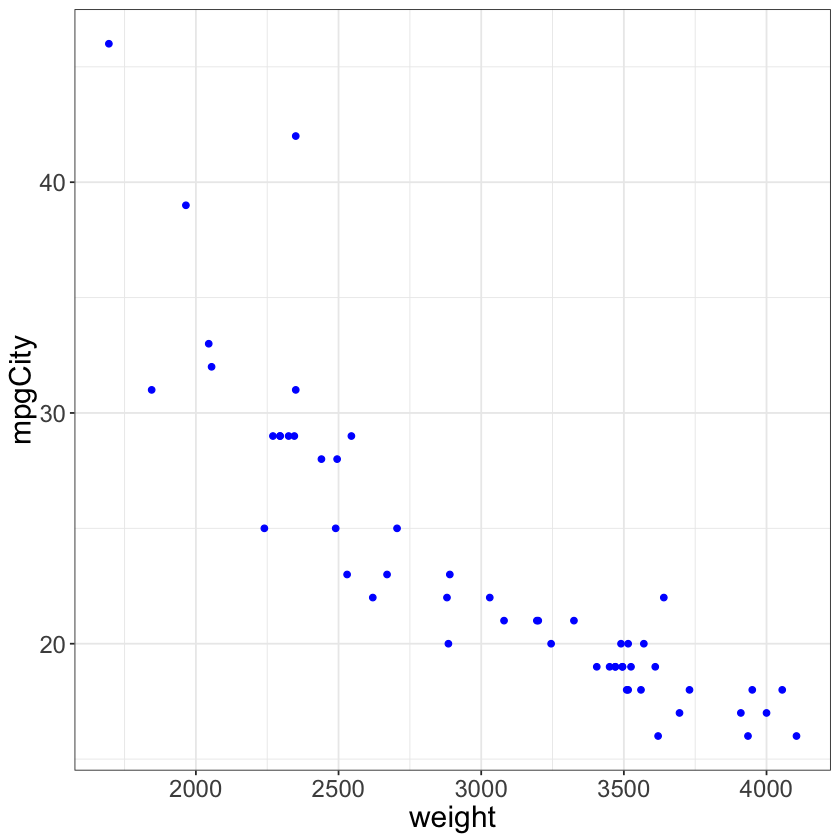

In [8]:
ggplot() +
    geom_point(data=cars, aes(weight, mpgCity))

ll <- function(beta, y, mX) {
    sum((y - apply(mX, 1, function(row) {sum(beta * row)}))^2)
}
X <- model.matrix( ~ weight, data=cars)

(beta <- optim(rexp(2), ll, method="L-BFGS-B", mX=X, y=cars$mpgCity)$par)

We write the estimated linear model as 

$$\hat{\mu} = \hat{\beta}_0 + \hat{\beta}_1*weight = 50.14 + -0.01*weight.$$

What's nice about this model is that we can easily interpret the parameters $\hat{\beta}_0 = 50.14$ and $\hat{\beta}_1 = -0.01$.  For instance, $\hat{\beta}_0$, better known as an intercept, is an estimate of (the population) city MPG for a car that weighs $0$ pounds.  While this doesn't make sense conceptually, this is the literal interpretation of the estimated intercept in the context of these data.  Notice that there's not data near $\text{weight} = 0$.  When this is the case, you can generally expect the intercept to not make much sense.

The slope, $\hat{\beta}_1$, describes the linear relationship between a car's weight and city MPG.  This estimate too is relatively easy to interpret in the context of these data.  For every 1 unit increase in a car's weight (a 1 pound increase), we estimate a $0.01$ decrease in the expected city MPG.  

Be careful to not overly interpret these estimates as describing a causal relationship.  Determining causal relationships from non-experimental data is no easy task, and we won't even try to broach this topic in this course.  Peter Norvig, Director of Research at Google, wrote an essay describing many of the difficulties of applied statistics practice surrounding observational data.  His essay [Warning Signs in Experimental Design and Interpretation](http://norvig.com/experiment-design.html) enumerates common warning signs for when a practioner of applied statistics might be misinterpreting their data.  For a more theoretical approach to determining causal relationships from data, see Judea Pearl's book [Causality](http://bayes.cs.ucla.edu/BOOK-2K/).

Just like before, the estimates $\hat{\beta}_0, \hat{\beta}_1$ are simply one set of estimates based on one random sample.  The values we produced could be due to pure random chance.  To better understand our uncertainty in these estimates, we will calculate confidence intervals.  We will let the function $\texttt{boot::boot}$ do the random sampling for us, and for that we need write a function that accepts our data and a vector of indices.

In [9]:
library(boot)

simple_reg <- function(data, idx) {
    y <- data[idx, 1]
    X <- data[idx, -1]
    optim(rexp(2), ll, method="BFGS", mX=X, y=y)$par
}

b <- boot(cbind(cars$mpgCity, X), R=999, simple_reg)
bci_beta0 <- boot.ci(b, conf=.9, type="perc", index=1)
bci_beta1 <- boot.ci(b, conf=.9, type="perc", index=2)

The $90\%$ confidence intervals for $\beta_0$ and $\beta_1$ are

In [10]:
bci_beta0
bci_beta1

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 999 bootstrap replicates

CALL : 
boot.ci(boot.out = b, conf = 0.9, type = "perc", index = 1)

Intervals : 
Level     Percentile     
90%   (45.16, 55.09 )  
Calculations and Intervals on Original Scale

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 999 bootstrap replicates

CALL : 
boot.ci(boot.out = b, conf = 0.9, type = "perc", index = 2)

Intervals : 
Level     Percentile     
90%   (-0.0103, -0.0074 )  
Calculations and Intervals on Original Scale

Some classes will make a big deal about the slope estimate not including $0$.  There's no doubt such conclusions have some appeal.  However, this too often encourages binary thinking such as, is the true population slope equal to zero or isn't it.  When a statistic, known as p-value, is smaller than $0.05$ or a confidence interval excludes zero, the common phrase is, statistically significantly different from zero, as if zero or not are the only options.

Increasingly, statisticians are warning against such binary decision making; e.g. ["It’s time to talk about ditching statistical significance"](https://www.nature.com/articles/d41586-019-00874-8), ["Moving to a World Beyond 'p < 0.05'"](https://www.tandfonline.com/doi/full/10.1080/00031305.2019.1583913), or ["Scientists rise up against statistical significance"](https://www.nature.com/articles/d41586-019-00857-9).

In this class, we'll focus on predictions, understanding uncertainty in our predictions, and making decisions in the face of this uncertainty.